# Phase estimation with QCNN

## Transverse field
---
Implement Variational Quantum Eigensolver algorithm for the system:
$$ H = \lambda \sum_{i}^{N} \sigma_z^i - \sum_{i}^{N-1} \sigma_{x}^{i+1}\sigma_x^i $$

where:
$$
\begin{align}
\sigma_z^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\sigma_x^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\end{align}
$$
Then train a Quantum Convolutional Neural Network.

Reproducing results from: https://arxiv.org/abs/1906.10155

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
N = 8

In [3]:
dev_vqe = qml.device('default.qubit', wires=N)

## States preparation through VQE

***Goal:*** Find the (lowest) upper-bound of the lowest <em>eigenvalue</em> (the <em>Ground-State</em>) of a given Hamiltonian.

$$\begin{align}
H \left|\psi\right> &= \lambda \left|\psi\right>\\
& \\
\left<\psi\right| H \left|\psi\right> &= \lambda \left<\psi\right|\left.\psi\right>\\
&\\
\frac{ \left<\psi\right| H \left|\psi\right> }{ \left<\psi\right|\left.\psi\right> } &= \lambda \equiv E_\lambda
\end{align}$$

***Algorithm***:
* 1\. Choose an Ansatz for initial $\left|\psi\right>$
* 2\. Initialize circuit with starting parameters $\vec{\theta_0}$
* 3\. For iteration in iterations
    * 3.1\. Pass $\left|\psi\right>$ through the $circuit(\vec{\theta})\,\,\to\,\,\left|\psi(\theta)\right>$
    * 3.2\. Compute $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$ (assuming normalization)
    * 3.3\. Update parameters $\theta$ to minimize $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$
    
    
<img src="https://qiskit.org/textbook/ch-applications/images/U3_var_form.png" alt="circ" width="500"> 


***Circuit***:

<img src="./imgs/ansatz.svg" alt="ansatz" width="1000"/>

In [4]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
        
    # Ising Ring
    # H = H + J*(-1)*( qml.PauliX(0) @ qml.PauliX(N-1) )
    
    return H

def vqe_circuit_1(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    
    # of Parameters: 5*N
    '''
    for spin in range(N):
        qml.RY(param[spin], wires = spin)
        qml.RX(param[N+spin], wires = spin)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    for spin in range(N):
        qml.RY(param[2*N   + spin], wires = spin)
        qml.RX(param[3*N   + spin], wires = spin)
    
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
        
    for spin in range(N):
        qml.RY(param[4*N + spin], wires = spin) 
        
def train_vqe_ising(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size    = Step size of the optimizer
    first_epochs = # epochs for first lambda (magnetic field)
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('first_epochs = {0} (# epochs for first GS)'.format(first_epochs))
    print('n_epochs     = {0} (# epochs for the other GSs'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
    
    # Build array of magnetic field intensities:
    # lams in [0, 2*J]
    lams = np.linspace(0,2*J,l_steps)
    
    # Array of energies for each final ground state found
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    # Since in order to find the other thetas we start from the optimized parameters of
    # the previous state, to reach a minimum, a less number of parameters is required
    if not first_epochs:
        first_epoch = n_epochs
    
    @qml.qnode(dev_vqe)
    def cost_fn(param):
        vqe_circuit_1(param, N)
        
        # return <psi|H|psi>
        return qml.expval(H)
    
    # Prepare initial state randomly
    thetas = np.array(np.random.randn(5*N), requires_grad = True)
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)

        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys      

***Parameters:***

step_size    = 0.2 (Step size of the optimizer)
first_epochs = 500 (# epochs for first GS)
n_epochs     = 50 (# epochs for the other GSs
N            = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(-0.36)──RX(-0.28)─╭C────────────────────||──RY(-0.81)──RX(-0.78)─╭C──RY(-1.56)──────────
1: ──RY(-0.29)──RX(-1.08)─╰X─╭C─────────────────||──RY(0.39)───RX(-0.62)─╰X─╭C──────────RY(0.13)
2: ──RY(-0.39)──RX(1.35)─────╰X─╭C──────────────||──RY(0.54)───RX(0.32)─────╰X─────────╭C───────
3: ──RY(-0.12)──RX(-0.82)───────╰X─╭C───────────||──RY(-0.31)──RX(0.04)────────────────╰X───────
4: ──RY(-2.04)──RX(0.75)───────────╰X─╭C────────||──RY(-0.21)──RX(-1.52)────────────────────────
5: ──RY(-0.10)──RX(0.20)──────────────╰X─╭C─────||──RY(-0.28)──RX(-1.02)────────────────────────
6: ──RY(0.42)───RX(1.14)─────────────────╰X─╭C──||──RY(1.37)───RX(1.73)─────────────────────────
7: ──RY(1.12)───RX(0.95)────────────────────╰X──||──RY(1.17)───RX(-0.99)────────────────────────

────────────────────────────────────────────────────────┤ ╭<𝓗>
────────────────────────────────────────────────────────┤ ├<𝓗>
───RY(-1.13)────────────────────────────────────────────┤ ├<𝓗>
──╭C──────────RY(0.48)────────────

  0%|          | 0/100 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


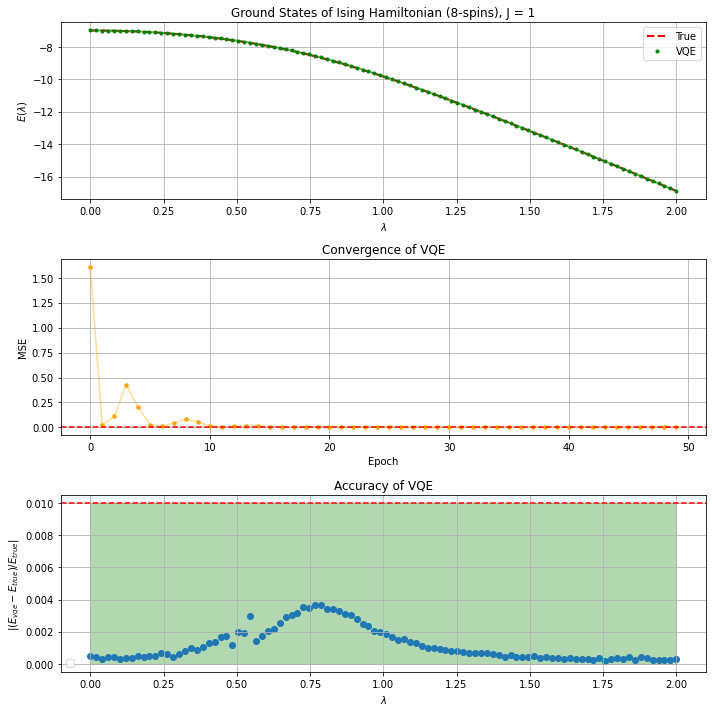

[[-1.52   0.889 -1.579 ... -1.571 -1.721  1.557]
 [-1.657  1.466 -1.58  ... -1.617 -1.583  1.442]
 [-1.542  2.096 -1.517 ... -1.491 -1.506  1.617]
 ...
 [-1.583  1.617 -1.598 ... -1.567 -1.578  1.563]
 [-1.504  1.549 -1.607 ... -1.556 -1.571  1.567]
 [-1.16   1.359 -1.612 ... -1.566 -1.578  1.564]]


/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [5]:
vqe_e, errs, thetas, ys = train_vqe_ising(step_size = 0.2, l_steps = 100, n_epochs = 50, N = N, J = 1,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_circuit_params.job')

print( np.round(np.asarray(thetas),3))

## Phase estimation through QCNN

Convolution layer:

<img src="./imgs/conv.svg" alt="conv" width="300"/>

Pooling block:

<img src="./imgs/pool.svg" alt="pool" width="500"/>

In [6]:
dev_qcnn = qml.device('default.qubit.jax', wires=N)

In [7]:
# Load data and separate in training and test set
data = joblib.load('./vqe_circuit_params.job')

print('Size of Data Set: {0}'.format(len(data)))

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [8]:
####################
## QCNN FUNCTIONS ##
####################

def num_params_qcnn(N):
    '''
    N = number of wires (spins)
    To evaluate the number of parameters needed for the qcnn
    a recursive function is needed:
    '''
    n_params = 0
    # While the number of wires is more than 1s
    while(N > 1):
        # Convolution
        n_params += 3*N
        # Pooling 
        n_params += 2*(N//2) + N%2
        # Reduce number of wires due to pooling
        N = N // 2 + N % 2
    
    # Last RY gate
    n_params += 1
    
    return n_params

def qcnn_convolution(active_wires, params, N, p_index):
    '''
    Convolution block for the QCNN
    '''
    # Check if the current number of wires is odd
    # it will be needed later.
    isodd = True if len(active_wires) % 2 != 0  else False
    
    # Convolution:
    for wire in active_wires:
        qml.RX(params[p_index],   wires = int(wire) )
        qml.RY(params[p_index+1], wires = int(wire) )
        p_index = p_index + 2
        
    # ---- > Establish entanglement: odd connections
    for wire, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
    # ---- > Establish entanglement: even connections
    for wire, wire_next in zip(active_wires[1::2], active_wires[2::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
    qml.RX(params[p_index], wires = N-1)
    p_index = p_index + 1

    return p_index
        
def qcnn_pooling(active_wires, params, N, p_index):
    '''
    Pooling block for the QCNN
    '''
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0  else False
    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        m_0 = qml.measure(int(wire_meas) )
        qml.cond(m_0 ==0, qml.RY)(params[p_index], wires=int(wire_next) )
        qml.cond(m_0 ==1, qml.RZ)(params[p_index+1], wires=int(wire_next) )
        p_index = p_index + 1
        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas) ) 
    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a Z gate
    if isodd:
        qml.RZ(params[p_index], wires = N-1)
        p_index = p_index + 1
        
    return p_index, active_wires

@qml.qnode(dev_qcnn, interface="jax", diff_method="best")     
def qcnn(params_vqe, params, N):
    '''
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)
    '''
    # Check on the size of the parameters:
    if len(params) != num_params_qcnn(N):
        raise ValueError('Invalid size of parameters')
        
    # Wires that are not measures (through pooling)
    active_wires = np.arange(N)
    
    # Input: State through VQE
    vqe_circuit_1(params_vqe, N)
    
    qml.Barrier()
    
    # Index of the parameter vector
    p_index = 0
    
    while(len(active_wires) > 1):
        p_index = qcnn_convolution(active_wires, params, N, p_index)
        qml.Barrier()
        p_index, active_wires = qcnn_pooling(active_wires, params, N, p_index)
        qml.Barrier()
    
    # Final Y rotation
    qml.RY(params[p_index], wires = N-1)
    
    return qml.probs(wires = N - 1)

# Estimation functions for QCNN
def cross_entropy(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

def cost_fn(params, X, Y, N):
    fn = lambda v: qcnn(v, params, N)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy(Y, predictions)
    
    return loss

def compute_cost_batch(X, Y, params, N):
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    circuit = lambda v: cost_fn(v, X, Y, N)
    
    return circuit(params)

def compute_cost(X, Y, params, batch_size, N):
    n_batches = jnp.shape(X)[0]//batch_size
    
    cost = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        
        cost = cost + compute_cost_batch(X_batch, Y_batch, params, N)
        
    return cost
        
def compute_accuracy_batch(X, Y, params, N):
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    fn = lambda v: qcnn(v, params, N)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)
    
    predictions = vcircuit(X)
    #print(jnp.argmax(predictions, axis=1)== Y)
    
    return (np.sum(jnp.argmax(predictions, axis=1) == jnp.asarray(Y)) )

def compute_accuracy(X, Y, params, batch_size, N):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    n_batches = jnp.shape(X)[0]//batch_size
    
    correctly_classified = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        
        correctly_classified += compute_accuracy_batch(X_batch, Y_batch, params, N)
    
    return 100*correctly_classified/jnp.shape(X)[0]

# Training function
def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr0 = 0.001, N = 8, plot = True, batch_size = 8):
    '''
    lr0          = Initial Learning Rate
    steps        = number of epochs for training
    first_epochs = # epochs for first lambda (magnetic field)
    batch_size   = size of the vmap of the jax-function
    N            = Number of spins/wires of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('lr0        = {0} (Initial learning rate)'.format(lr0))
    print('steps      = {0} (# epochs)'.format(steps))
    print('batch_size = {0} (size of the jax-vmap)'.format(batch_size))
    print('N          = {0} (Number of spins of the system)'.format(N))
    
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(num_params_qcnn(N)) )
    
    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    lr = lr0
    for epoch in progress:
        lr = lr0*(np.exp(-0.01*epoch))
        
        # Compute current loss and update parameters
        for batch in range(n_batches+1):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            
            if start_batch == end_batch:
                break
                
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])

            circuit = lambda v: cost_fn(v, X_batch, Y_batch, N)
            grad_circuit = jax.grad(circuit)
            params -= lr*grad_circuit(params)
        
        if epoch % 10 == 0:
            loss_history.append(compute_cost(X_train, Y_train, params, 16, N) )
            accuracy_history.append( compute_accuracy(X_train, Y_train, params, 16, N) )
            
            if len(X_test) > 0:
                accuracy_history_test.append(compute_accuracy(X_test, Y_test, params, 16, N) )
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, batch_size, N) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

def plot_results_classification(data, train_index, params, N):
    test_index = []
    for i in range(len(data)):
        if not i in train_index:
            test_index.append(i)
    
    predictions_train = []
    predictions_test  = []

    colors_train = []
    colors_test  = []

    for i in range(len(data)):
        prediction = qcnn(data[i][0],params,N)[1]

        # if data in training set
        if i in train_index:
            predictions_train.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_train.append('green')
                else:
                    colors_train.append('red')
            else:
                if i <= len(data)/2:
                    colors_train.append('red')
                else:
                    colors_train.append('green')
        else:
            predictions_test.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_test.append('green')
                else:
                    colors_test.append('red')
            else:
                if i <= len(data)/2:
                    colors_test.append('red')
                else:
                    colors_test.append('green')
    
    fig, ax = plt.subplots(2, 1, figsize=(16,10))

    ax[0].set_xlim(-0.1,2.1)
    ax[0].set_ylim(0,1)
    ax[0].grid(True)
    ax[0].axhline(y=.5, color='gray', linestyle='--')
    ax[0].axvline(x=1, color='gray', linestyle='--')
    ax[0].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[0].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[0].set_xlabel('Transverse field')
    ax[0].set_ylabel('Prediction of label II')
    ax[0].set_title('Predictions of labels; J = 1')
    ax[0].scatter(2*np.sort(train_index)/len(data), predictions_train, c = 'royalblue', label='Training samples')
    ax[0].scatter(2*np.sort(test_index)/len(data), predictions_test, c = 'orange', label='Test samples')
    ax[0].legend()

    ax[1].set_xlim(-0.1,2.1)
    ax[1].set_ylim(0,1)
    ax[1].grid(True)
    ax[1].axhline(y=.5, color='gray', linestyle='--')
    ax[1].axvline(x=1, color='gray', linestyle='--')
    ax[1].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[1].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[1].set_xlabel('Transverse field')
    ax[1].set_ylabel('Prediction of label II')
    ax[1].set_title('Predictions of labels; J = 1')
    ax[1].scatter(2*np.sort(train_index)/len(data), predictions_train, c = colors_train)
    ax[1].scatter(2*np.sort(test_index)/len(data), predictions_test, c = colors_test)

In [9]:
drawer = qml.draw(qcnn)
print(drawer([0]*100,[0]*num_params_qcnn(N), N))

0: ──RY(0.00)──RX(0.00)─╭C────────────────────||──RY(0.00)──RX(0.00)─╭C──RY(0.00)──────────
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────────────────||──RY(0.00)──RX(0.00)─╰X─╭C─────────RY(0.00)
2: ──RY(0.00)──RX(0.00)────╰X─╭C──────────────||──RY(0.00)──RX(0.00)────╰X────────╭C───────
3: ──RY(0.00)──RX(0.00)───────╰X─╭C───────────||──RY(0.00)──RX(0.00)──────────────╰X───────
4: ──RY(0.00)──RX(0.00)──────────╰X─╭C────────||──RY(0.00)──RX(0.00)───────────────────────
5: ──RY(0.00)──RX(0.00)─────────────╰X─╭C─────||──RY(0.00)──RX(0.00)───────────────────────
6: ──RY(0.00)──RX(0.00)────────────────╰X─╭C──||──RY(0.00)──RX(0.00)───────────────────────
7: ──RY(0.00)──RX(0.00)───────────────────╰X──||──RY(0.00)──RX(0.00)───────────────────────

─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭C──RX(0.00)───
─────────────────────────────────────────────────────||──RX(0.00)──RY(0.00)─╰X───────────╭C
───RY(0.00)──────────────────────────────────────────||──RX(0.00)──RY(0.00)─╭C─

In [ ]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, X_test, Y_test, lr0 = 15e-2, steps = 500, batch_size = 16)


***Parameters:***

lr0        = 0.15 (Initial learning rate)
steps      = 500 (# epochs)
batch_size = 16 (size of the jax-vmap)
N          = 8 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
plot_results_classification(data, train_index, params, N)

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)

---
## Backup code

## Backup code 1: Shift-invariant Ansatz

Each rotation layer are 4 parameters:
* 1 for the first wire/spin
* 1 for the even wires
* 1 for the odd wires
* 1 for the last wire/spin

<img src="./imgs/siansatz.svg" alt="ansatz" width="1000"/>

In [ ]:
dev_vqe_backup = qml.device('default.qubit', wires=10)

def vqe_circuit_2(param, N = 8):
    '''
    Build the circuit to find the Groud-State of the 
    Ising-Chain Hamiltonian
    '''
    qml.RY(param[0], wires = 0)
    qml.RX(param[1], wires = 0)
    
    qml.RY(param[2], wires = N - 1)
    qml.RX(param[3], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[4], wires = spin)
        qml.RY(param[5], wires = spin+1)
        qml.RX(param[6], wires = spin)
        qml.RX(param[7], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
    
    qml.Barrier()
    
    qml.RY(param[8], wires = 0)
    qml.RX(param[9], wires = 0)
    
    qml.RY(param[10], wires = N - 1)
    qml.RX(param[11], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RY(param[12], wires = spin)
        qml.RY(param[13], wires = spin+1)
        qml.RX(param[14], wires = spin)
        qml.RX(param[15], wires = spin+1)
        
    # Apply entanglement to the neighbouring spins
    for spin in range(N-1):
        qml.CNOT(wires = [spin, spin+1])
     
    qml.RX(param[16], wires = 0)
    qml.RX(param[17], wires = N - 1)
    
    qml.RY(param[18], wires = 0)
    qml.RY(param[19], wires = N - 1)
    
    for spin in range(1,N-1,2):
        qml.RX(param[20], wires = spin)
        qml.RX(param[21], wires = spin+1)
        qml.RY(param[22], wires = spin)
        qml.RY(param[23], wires = spin+1)

def train_vqe_ising_shiftinvariant(step_size, l_steps, n_epochs, N, J, dev, circuit = False, plots = False, first_epochs = False):
    '''
    step_size = Step size of the optimizer
    epochs    = # epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (# epochs for each lambda)'.format(n_epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    
    lams = np.linspace(0,2*J,l_steps)
    
    vqe_e = []
    errs = np.zeros((n_epochs, len(lams)) )
    
    @qml.qnode(dev_vqe_backup)
    def cost_fn(param):
        vqe_circuit_2(param, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    thetas = np.array(np.random.randn(24), requires_grad = True) # Prepare initial state
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(thetas))
    
    thetas_arr = []
    ys = [] # Labels of the phase
    for i, l in enumerate(tqdm(lams)):
        opt = qml.AdamOptimizer(stepsize=step_size)
        H = qml_build_H(N, float(l), J)
        
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = np.min(qml.eigvals(H))
        
        epochs = first_epochs if i == 0 else n_epochs
        
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            if i != 0:
                if epoch < n_epochs:
                    errs[epoch-1, i] = (prev_energy - GS_H)**2
            
        vqe_e.append(cost_fn(thetas))
        thetas_arr.append(thetas)
        ys.append(0) if l <= J else ys.append(1)
        
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l), J)
            true_e.append(np.min(qml.eigvals(H)) )
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()
        plt.show()
        
         
        
    return vqe_e, errs, thetas_arr, ys   

In [ ]:
vqe_e, errs, thetas, ys = train_vqe_ising_shiftinvariant(step_size = 0.05, l_steps = 100, n_epochs = 50, N = 8, J = 1,
                                              dev = dev_vqe, circuit = True, plots = True, first_epochs = 500)

## Backup code 2: Weighted loss

***Idea***: Add a higher weight to the samples near the phase transition in the error computation.

In [ ]:
def set_weights(strenght, sigma, data):
    W = []
    for k in range(len(data)):
        x = 2*k/(len(data))
        W.append( strenght*np.exp(-(1/sigma)*(x-1)**2) + 1)
        
    return W

In [ ]:
def cross_entropy_weighted(labels, predictions, weights):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p, w in zip(labels, predictions, weights):
        c_entropy = ( l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l]) )
        loss = loss + w*c_entropy

    return -1 * loss

def cost_fn_weighted(params, X, Y, W, N):
    fn = lambda v: qcnn(v, params, N)
    # Create a vectorized version of our original circuit.
    vcircuit = jax.vmap(fn)

    predictions = vcircuit(X)
    #predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy_weighted(Y, predictions, W)
    
    return loss

def compute_cost_batch_weighted(X, Y, W, params, N):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X)
    
    if data_len == 0:
        return 0
    
    circuit = lambda v: cost_fn_weighted(v, X, Y, W, N)
    
    return circuit(params)

def compute_cost_weighted(X, Y, W, params, batch_size, N):
    n_batches = jnp.shape(X)[0]//batch_size
    
    cost = 0
    for batch in range(n_batches+1):
        start_batch = batch*(batch_size)
        end_batch = min( (batch+1)*(batch_size), jnp.shape(X)[0] )
        
        X_batch, Y_batch = jnp.array(X[start_batch:end_batch]), jnp.array(Y[start_batch:end_batch])
        W_batch = jnp.array(W[start_batch:end_batch])
        
        cost = cost + compute_cost_batch_weighted(X_batch, Y_batch, W_batch, params, N)
        
    return cost

# Training function
def qcnn_training_weighted(X_train, Y_train, W_train, X_test = [], Y_test = [], steps = 100, lr0 = 0.001, N = 8, plot = True, batch_size = 8):
    # Initialize parameters randomly
    params = jnp.array( np.random.randn(72) )
    
    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    progress = tqdm(range(steps))
    
    n_batches      = jnp.shape(X_train)[0]//batch_size
    n_batches_test = jnp.shape(X_test)[0]//batch_size
    
    lr = lr0
    for epoch in progress:
        lr = lr0*(np.exp(-0.01*epoch))
        
        # Compute current loss and update parameters
        for batch in range(n_batches+1):
            params_batch = copy.copy(params)
            
            start_batch = (batch)*(batch_size)
            end_batch = min( (batch+1)*(batch_size), jnp.shape(X_train)[0] )
            
            if start_batch == end_batch:
                break
                
            X_batch, Y_batch = jnp.array(X_train[start_batch:end_batch]), jnp.array(Y_train[start_batch:end_batch])
            W_batch =jnp.array(W_train[start_batch:end_batch])
            
            circuit = lambda v: cost_fn_weighted(v, X_batch, Y_batch, W_batch, N)
            grad_circuit = jax.grad(circuit)
            params -= lr*grad_circuit(params)
        
        if epoch % 10 == 0:
            loss_history.append(compute_cost_weighted(X_train, Y_train, W_train, params, 16, N) )
            accuracy_history.append( compute_accuracy(X_train, Y_train, params, 16, N) )
            
            if len(X_test) > 0:
                accuracy_history_test.append(compute_accuracy(X_test, Y_test, params, 16, N) )
        
        # Set description to current loss
        progress.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],3), accuracy_history[-1]) )
        
    print('Accuracy on Training Set: {0}'.format(compute_accuracy(X_train, Y_train, params, batch_size, N) ) )

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [ ]:
W = np.array(set_weights(5, 0.1, data))

In [ ]:
plt.plot(W)
plt.ylim(0,np.max(W)+1)
plt.grid(True)
plt.title('Weights')

In [ ]:
W_train = W[train_index]

In [ ]:
weighted_loss_history, weighet_accuracy_history, weighted_params = qcnn_training_weighted(X_train, Y_train, W_train, X_test, Y_test, 
                                                                steps = 500, lr0 = 5e-2, N = 8, plot = True, batch_size = 16)

In [ ]:
plot_results_classification(data, train_index, weighted_params, N)

In [ ]:
joblib.dump(weighted_params, './qcnn_params.job')